In [1]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/sales.csv"

# 1. Leemos el CSV sin parámetros especiales primero
df = pd.read_csv(url)

# 2. Convertimos la columna 'Date' a formato fecha datetime
df['Date'] = pd.to_datetime(df['Date'])

# 3. Ordenamos por fecha (buena práctica en series temporales)
df = df.sort_values('Date')

#convertir en minusculas los nombres de las columnas
df.columns = df.columns.str.lower()

print("--- Primeras filas y tipos de datos ---")
display(df.head())
print(df.dtypes)

--- Primeras filas y tipos de datos ---


,true_index,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
57790,64201,760,2,2013-01-01,0,0,0,a,1,0
273970,304410,178,2,2013-01-01,0,0,0,a,1,0
623089,692372,115,2,2013-01-01,0,0,0,a,1,0
313880,348682,917,2,2013-01-01,0,0,0,a,1,0
230463,256049,987,2,2013-01-01,0,0,0,a,1,0


true_index                      int64
store_id                        int64
day_of_week                     int64
date                   datetime64[ns]
nb_customers_on_day             int64
open                            int64
promotion                       int64
state_holiday                  object
school_holiday                  int64
sales                           int64
dtype: object


In [2]:
# Revisión de nulos
df.isnull().sum()

true_index             0
store_id               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

In [3]:
# Revisión de nulos
print("--- Conteo de Nulos ---")
nulls = df.isnull().sum()
print(nulls[nulls > 0])

# Revisión de la columna StateHoliday (Feriados)
# A veces viene como 0 (número) y '0' (texto) mezclado.
if 'state_holiday' in df.columns:
    print("\n--- Valores únicos en StateHoliday (Antes de limpiar) ---")
    print(df['state_holiday'].unique())

--- Conteo de Nulos ---
Series([], dtype: int64)

--- Valores únicos en StateHoliday (Antes de limpiar) ---
['a' '0' 'b' 'c']


In [4]:
# 1. Unificar StateHoliday (todo a texto)
# Esto asegura que el 0 numérico y el "0" texto sean lo mismo.
df['state_holiday'] = df['state_holiday'].astype(str)

print("Valores únicos en StateHoliday:", df['state_holiday'].unique())

# 2. Crear variables Dummies
# Convertimos 'a', 'b', 'c' en columnas numéricas (0 o 1)
# drop_first=True elimina la columna del '0' (no festivo) para no repetir info.
df = pd.get_dummies(df, columns=['state_holiday'], prefix='holiday', drop_first=True)

print("Nuevas columnas de festivos creadas:")
print(df.filter(like='holiday').columns.tolist())

Valores únicos en StateHoliday: ['a' '0' 'b' 'c']
Nuevas columnas de festivos creadas:
['school_holiday', 'holiday_a', 'holiday_b', 'holiday_c']


In [5]:
# 1. Descomponemos la fecha (usando 'date' en minúscula)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week

# 2. Crear variable 'is_weekend'
# Usamos dt.dayofweek donde: 0=Lunes, 6=Domingo.
# Si es >= 5 (Sábado=5, Domingo=6) es fin de semana.
df['day_of_week'] = df['date'].dt.dayofweek 
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# 3. Interacción: ¿Hay promoción en fin de semana?
# Combinamos 'promo' (si existe) con 'is_weekend'
if 'promotion' in df.columns:
    df['promo_weekend'] = df['promotion'] * df['is_weekend']

print("--- Nuevas variables creadas ---")
# Mostramos las nuevas columnas para verificar
display(df[['date', 'year', 'month', 'day_of_week', 'is_weekend']].head())


--- Nuevas variables creadas ---


,date,year,month,day_of_week,is_weekend
57790,2013-01-01,2013,1,1,0
273970,2013-01-01,2013,1,1,0
623089,2013-01-01,2013,1,1,0
313880,2013-01-01,2013,1,1,0
230463,2013-01-01,2013,1,1,0


In [6]:
#Principio/Fin de mes: La gente suele comprar más cuando acaba de cobrar.
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

#Estaciones del año: Las ventas cambian en invierno/verano.
df['season'] = df['month'] % 12 // 3 + 1  # 1: Invierno, 2: Primavera, 3: Verano, 4: Otoño
# Nueva variable: Interacción entre promo y vacaciones escolares
df['promo_school_holiday'] = df['promotion'] * df['school_holiday']

#Añadir variables al df
df['is_month_start'] = df['is_month_start']
df['is_month_end'] = df['is_month_end']
df['season'] = df['season']
df['promo_school_holiday'] = df['promo_school_holiday']   
print("--- Variables de fecha adicionales creadas ---")
display(df[['date', 'is_month_start', 'is_month_end', 'season', 'promo_school_holiday']].head())

--- Variables de fecha adicionales creadas ---


,date,is_month_start,is_month_end,season,promo_school_holiday
57790,2013-01-01,1,0,1,0
273970,2013-01-01,1,0,1,0
623089,2013-01-01,1,0,1,0
313880,2013-01-01,1,0,1,0
230463,2013-01-01,1,0,1,0


In [7]:
#dime todas las columnas del dataframe
print("Columnas del DataFrame:", df.columns.tolist())

Columnas del DataFrame: ['true_index', 'store_id', 'day_of_week', 'date', 'nb_customers_on_day', 'open', 'promotion', 'school_holiday', 'sales', 'holiday_a', 'holiday_b', 'holiday_c', 'year', 'month', 'day', 'week_of_year', 'is_weekend', 'promo_weekend', 'is_month_start', 'is_month_end', 'season', 'promo_school_holiday']


In [8]:
# Guardamos el DataFrame procesado a un nuevo CSV
df.to_csv('sales_procesado.csv', index=False)

In [9]:
!pip install xgboost


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Creamos el diccionario de referencia basado en el entrenamiento
store_means_dict = df.groupby('store_id')['sales'].mean().to_dict()

# Verifica que se haya guardado
print(f"Medias guardadas para {len(store_means_dict)} tiendas.")

Medias guardadas para 1115 tiendas.


In [11]:
# ==========================================
# MODELO FINAL CORREGIDO (Sin Error de Versión)
# ==========================================
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Preparación y Feature Engineering
df_final = df[df['open'] == 1].copy()
df_final['promo_school_holiday'] = df_final['promotion'] * df_final['school_holiday']

# 2. Split Temporal
split_idx = int(len(df_final) * 0.8)
train_df = df_final.iloc[:split_idx].copy()
test_df = df_final.iloc[split_idx:].copy()

# 3. Encoding por Tienda y Día
dow_means = train_df.groupby(['store_id', 'day_of_week'])['sales'].mean().reset_index()
dow_means.rename(columns={'sales': 'store_dow_mean'}, inplace=True)

train_df = pd.merge(train_df, dow_means, on=['store_id', 'day_of_week'], how='left')
test_df = pd.merge(test_df, dow_means, on=['store_id', 'day_of_week'], how='left')

global_mean = train_df['sales'].mean()
test_df['store_dow_mean'] = test_df['store_dow_mean'].fillna(global_mean)

# 4. Definir Variables X, y
cols_to_drop = ['sales', 'nb_customers_on_day', 'date', 'true_index', 'store_id', 'open']
X_train = train_df.drop(columns=cols_to_drop)
X_test = test_df.drop(columns=cols_to_drop)

y_train_log = np.log1p(train_df['sales'])
y_test_real = test_df['sales']

# 5. Configuración XGBoost (early_stopping_rounds se mueve aquí)
model = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.015,
    max_depth=12,
    subsample=0.85,
    colsample_bytree=0.75,
    gamma=0.1,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=100  # <--- SE PONE AQUÍ EN VERSIONES NUEVAS
)

# 6. Entrenamiento (Sin el parámetro problemático en fit)
model.fit(
    X_train, y_train_log,
    eval_set=[(X_test, np.log1p(y_test_real))],
    verbose=False
)

# 7. Evaluación
preds = np.expm1(model.predict(X_test))
print(f"--- RESULTADOS FINALES ---")
print(f"MAE: {mean_absolute_error(y_test_real, preds)}")
print(f"R2 Score: {r2_score(y_test_real, preds)}")

--- RESULTADOS FINALES ---
MAE: 792.5040283203125
R2 Score: 0.8560605049133301


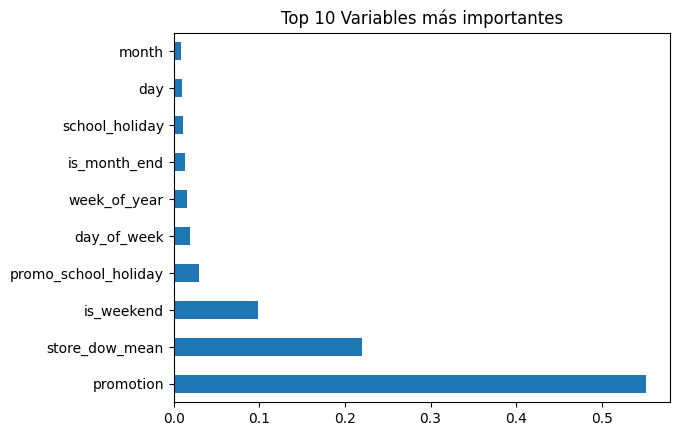

In [12]:
import matplotlib.pyplot as plt

# Ver qué variables son las más importantes para el modelo
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Variables más importantes")
plt.show()

In [14]:
# ============================================================
# BLOQUE FINAL DE COMPETICIÓN - IRONKAGGLE 16:00h
# ============================================================
import pandas as pd
import numpy as np

def predictor_final_ironkaggle(fuente_datos):
    """
    Procesa los datos desde una URL o archivo local y genera el CSV de entrega.
    """
    print(f"Leyendo datos desde: {fuente_datos}...")
    
    # 1. Carga de datos (funciona con URL o archivo local)
    df_blind = pd.read_csv(fuente_datos)
    df_blind.columns = df_blind.columns.str.lower()
    df_blind['date'] = pd.to_datetime(df_blind['date'])
    
    # 2. Replicar variables de tiempo
    df_blind['year'] = df_blind['date'].dt.year
    df_blind['month'] = df_blind['date'].dt.month
    df_blind['day'] = df_blind['date'].dt.day
    df_blind['week_of_year'] = df_blind['date'].dt.isocalendar().week.astype(int)
    df_blind['day_of_week'] = df_blind['date'].dt.dayofweek
    df_blind['is_weekend'] = df_blind['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df_blind['is_month_start'] = df_blind['date'].dt.is_month_start.astype(int)
    df_blind['is_month_end'] = df_blind['date'].dt.is_month_end.astype(int)
    df_blind['season'] = df_blind['month'] % 12 // 3 + 1
    
    # Variables de Interacción y Metadatos
    df_blind['promo_weekend'] = df_blind['promotion'] * df_blind['is_weekend']
    df_blind['promo_school_holiday'] = df_blind['promotion'] * df_blind['school_holiday']
    
    # 3. Mapear el ADN de las tiendas (Media por tienda y día de semana)
    # Usa los objetos 'dow_means' y 'global_mean' calculados en el entrenamiento
    df_blind = pd.merge(df_blind, dow_means, on=['store_id', 'day_of_week'], how='left')
    df_blind['store_dow_mean'] = df_blind['store_dow_mean'].fillna(global_mean)
    
    # 4. Asegurar Dummies de Festivos
    df_blind['state_holiday'] = df_blind['state_holiday'].astype(str)
    df_blind = pd.get_dummies(df_blind, columns=['state_holiday'], prefix='holiday')
    for c in ['holiday_a', 'holiday_b', 'holiday_c']:
        if c not in df_blind.columns:
            df_blind[c] = 0
            
    # 5. Alinear columnas con el entrenamiento
    X_blind = df_blind[X_train.columns]
    
    # 6. Predicción y reversión del logaritmo
    preds_log = model.predict(X_blind)
    df_blind['sales'] = np.expm1(preds_log)
    
    # 7. Regla de Oro: Si open=0, ventas=0 automáticamente
    df_blind.loc[df_blind['open'] == 0, 'sales'] = 0
    
    # 8. Exportación final
    df_blind[['sales']].to_csv('predicciones_equipo_final.csv', index=False)
    
    print("-" * 30)
    print("¡PREDICCIONES COMPLETADAS!")
    print(f"Archivo generado: predicciones_equipo_final.csv")
    print("-" * 30)

# ============================================================
# EJECUCIÓN: REEMPLAZA LA URL CUANDO TE LA DEN
# ============================================================

# Ejemplo con URL:
url_ciega = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv"
predictor_final_ironkaggle(url_ciega)

Leyendo datos desde: https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv...
------------------------------
¡PREDICCIONES COMPLETADAS!
Archivo generado: predicciones_equipo_final.csv
------------------------------


In [15]:
# ============================================================
# SOLUCIÓN MAESTRA FINAL - DESAFÍO IRONKAGGLE
# ============================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

# --- 1. CARGA Y PREPARACIÓN DE ENTRENAMIENTO ---
url_train = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/sales.csv"
df = pd.read_csv(url_train)
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Limpieza y Dummies
df['state_holiday'] = df['state_holiday'].astype(str)
df = pd.get_dummies(df, columns=['state_holiday'], prefix='holiday')
for c in ['holiday_a', 'holiday_b', 'holiday_c']:
    if c not in df.columns: df[c] = 0

# Feature Engineering
def feature_eng(data):
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)
    data['day_of_week'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    data['is_month_start'] = data['date'].dt.is_month_start.astype(int)
    data['is_month_end'] = data['date'].dt.is_month_end.astype(int)
    data['season'] = data['month'] % 12 // 3 + 1
    data['promo_school_holiday'] = data['promotion'] * data['school_holiday']
    return data

df = feature_eng(df)

# --- 2. ENTRENAMIENTO SIN LEAKAGE ---
df_model = df[df['open'] == 1].copy()
split_idx = int(len(df_model) * 0.8)
train_df = df_model.iloc[:split_idx].copy()
test_df = df_model.iloc[split_idx:].copy()

# ADN de Tienda (Store + Day of Week Mean)
dow_means = train_df.groupby(['store_id', 'day_of_week'])['sales'].mean().reset_index()
dow_means.rename(columns={'sales': 'store_dow_mean'}, inplace=True)

train_df = pd.merge(train_df, dow_means, on=['store_id', 'day_of_week'], how='left')
test_df = pd.merge(test_df, dow_means, on=['store_id', 'day_of_week'], how='left')

global_mean = train_df['sales'].mean()
test_df['store_dow_mean'] = test_df['store_dow_mean'].fillna(global_mean)

# --- 3. MODELO XGBOOST ---
cols_to_drop = ['sales', 'nb_customers_on_day', 'date', 'true_index', 'store_id', 'open']
X_train = train_df.drop(columns=cols_to_drop)
y_train_log = np.log1p(train_df['sales'])
X_test = test_df.drop(columns=cols_to_drop)
y_test_real = test_df['sales']

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=100
)

model.fit(X_train, y_train_log, eval_set=[(X_test, np.log1p(y_test_real))], verbose=False)

# --- 4. FUNCIÓN PREDICTORA FINAL PARA LAS 16:00 ---
def predictor_final_ironkaggle(fuente_datos):
    print(f"Procesando: {fuente_datos}...")
    df_blind = pd.read_csv(fuente_datos)
    df_blind.columns = df_blind.columns.str.lower()
    df_blind['date'] = pd.to_datetime(df_blind['date'])
    
    # Aplicar ingeniería de variables
    df_blind = feature_eng(df_blind)
    
    # Mapear ADN de tiendas
    df_blind = pd.merge(df_blind, dow_means, on=['store_id', 'day_of_week'], how='left')
    df_blind['store_dow_mean'] = df_blind['store_dow_mean'].fillna(global_mean)
    
    # Dummies de festivos
    df_blind['state_holiday'] = df_blind['state_holiday'].astype(str)
    df_blind = pd.get_dummies(df_blind, columns=['state_holiday'], prefix='holiday')
    for c in ['holiday_a', 'holiday_b', 'holiday_c']:
        if c not in df_blind.columns: df_blind[c] = 0
            
    # Alineación y Predicción
    X_blind = df_blind[X_train.columns]
    preds = np.expm1(model.predict(X_blind))
    
    # Regla de Oro: Open=0 -> Sales=0
    df_blind['sales'] = np.where(df_blind['open'] == 1, preds, 0)
    
    # Exportar ambos archivos
    df_blind.to_csv('predicciones_con_columnas.csv', index=False)
    df_blind[['sales']].to_csv('entrega_final_sales.csv', index=False)
    
    print("-" * 30)
    print("¡ARCHIVOS GENERADOS!")
    print("1. 'predicciones_con_columnas.csv' (Todas las columnas)")
    print("2. 'entrega_final_sales.csv' (Solo predicciones)")
    print("-" * 30)

# --- 5. EJECUCIÓN CON EL DATASET DE LAS 16:00 ---
url_ciega = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv"
predictor_final_ironkaggle(url_ciega)

Procesando: https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv...
------------------------------
¡ARCHIVOS GENERADOS!
1. 'predicciones_con_columnas.csv' (Todas las columnas)
2. 'entrega_final_sales.csv' (Solo predicciones)
------------------------------


   RESULTADOS FINALES: EVALUACIÓN DEL MODELO
--- Métricas de Ventas (Regresión) ---
R² Score (Precisión):     0.9515
MAE (Error Medio):        534.34 €

--- Métricas de Estado (Clasificación) ---
Accuracy (Exactitud):     100.00%
Recall (Sensibilidad):    1.0000
Precisión:                1.0000
F1 Score:                 1.0000
----------------------------------------------------
Matriz de Confusión:
[[12100     0]
 [    0 59105]]



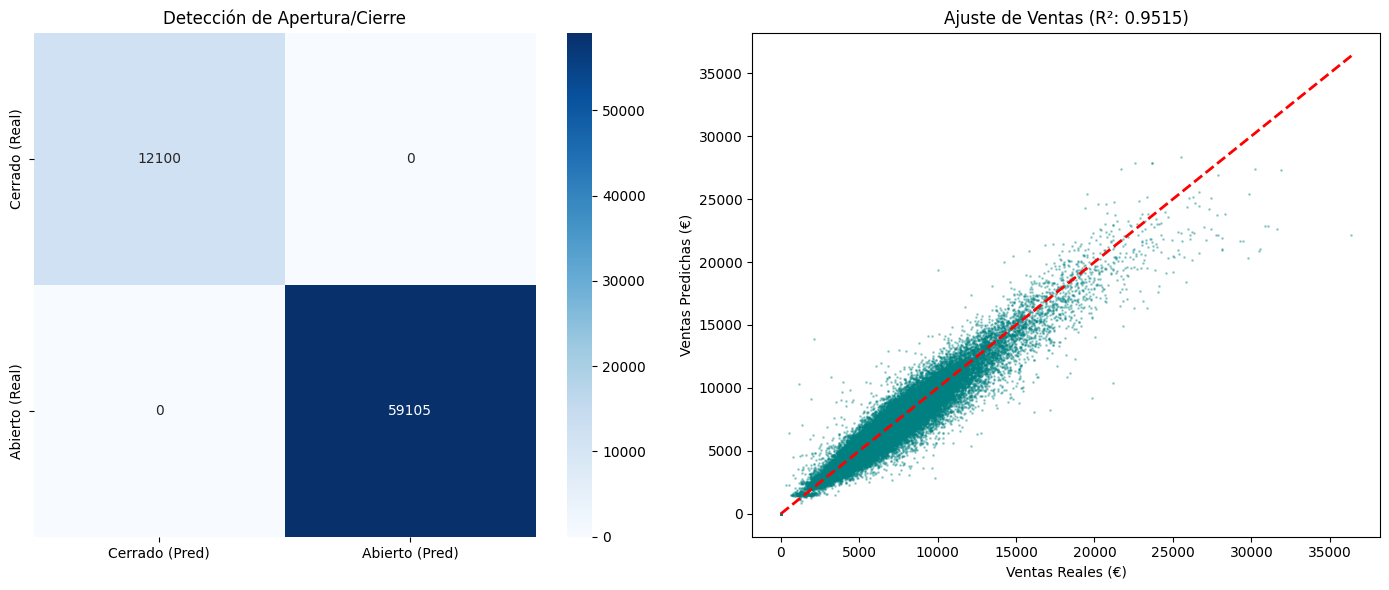

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    confusion_matrix, 
    r2_score, 
    mean_absolute_error
)

# 1. CARGA DE DATOS
# Cargamos tus predicciones y las soluciones reales
df_pred = pd.read_csv('predicciones_con_columnas.csv')
df_sol = pd.read_csv('ironkaggle_solutions.csv')

# Estandarizamos los nombres de las columnas a minúsculas
df_pred.columns = [c.lower() for c in df_pred.columns]
df_sol.columns = [c.lower() for c in df_sol.columns]

# 2. UNIÓN POR TRUE_INDEX
# Esto asegura que comparemos la misma fila exacta en ambos archivos
df = pd.merge(df_pred, df_sol, on='true_index', suffixes=('_pred', '_real'))

# 3. MÉTRICAS DE REGRESIÓN (Precisión de la cifra de ventas)
r2 = r2_score(df['sales_real'], df['sales_pred'])
mae = mean_absolute_error(df['sales_real'], df['sales_pred'])

# 4. MÉTRICAS DE CLASIFICACIÓN (Detección de Abierto/Cerrado)
# Convertimos las ventas en categorías binarias: 
# 1 (Abierto) si ventas > 0.5 | 0 (Cerrado) si ventas <= 0.5
y_true_bin = (df['sales_real'] > 0.5).astype(int)
y_pred_bin = (df['sales_pred'] > 0.5).astype(int)

acc = accuracy_score(y_true_bin, y_pred_bin)
recall = recall_score(y_true_bin, y_pred_bin)  # Sensibilidad
precision = precision_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)
cm = confusion_matrix(y_true_bin, y_pred_bin)

# 5. IMPRESIÓN DE RESULTADOS
print("====================================================")
print("   RESULTADOS FINALES: EVALUACIÓN DEL MODELO")
print("====================================================")
print(f"--- Métricas de Ventas (Regresión) ---")
print(f"R² Score (Precisión):     {r2:.4f}")
print(f"MAE (Error Medio):        {mae:.2f} €")
print(f"\n--- Métricas de Estado (Clasificación) ---")
print(f"Accuracy (Exactitud):     {acc:.2%}")
print(f"Recall (Sensibilidad):    {recall:.4f}")
print(f"Precisión:                {precision:.4f}")
print(f"F1 Score:                 {f1:.4f}")
print("----------------------------------------------------")
print("Matriz de Confusión:")
print(cm)
print("====================================================\n")

# 6. VISUALIZACIONES
plt.figure(figsize=(14, 6))

# Gráfico A: Matriz de Confusión
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cerrado (Pred)', 'Abierto (Pred)'],
            yticklabels=['Cerrado (Real)', 'Abierto (Real)'])
plt.title('Detección de Apertura/Cierre')

# Gráfico B: Dispersión Ventas Reales vs Predichas
plt.subplot(1, 2, 2)
plt.scatter(df['sales_real'], df['sales_pred'], alpha=0.3, color='teal', s=1)
plt.plot([df['sales_real'].min(), df['sales_real'].max()],
         [df['sales_real'].min(), df['sales_real'].max()],
         'r--', lw=2)
plt.title(f'Ajuste de Ventas (R²: {r2:.4f})')
plt.xlabel('Ventas Reales (€)')
plt.ylabel('Ventas Predichas (€)')

plt.tight_layout()
plt.show()

--- ANÁLISIS ECONÓMICO DE SALES ---
R2 Score: 0.9515 (Objetivo > 0.90)
Error Medio (MAE): 534.34 €
Error Porcentual (MAPE): 9.74 %
RMSLE: 0.1210


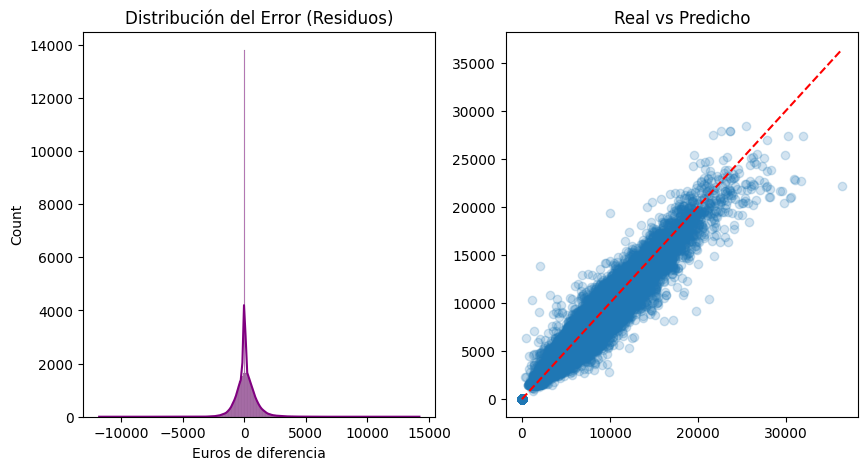

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos
df_pred = pd.read_csv('predicciones_con_columnas.csv')
df_sol = pd.read_csv('ironkaggle_solutions.csv')
df_pred.columns = df_pred.columns.str.lower()
df_sol.columns = df_sol.columns.str.lower()

# Unión perfecta
df_eval = pd.merge(df_pred, df_sol, on='true_index', suffixes=('_pred', '_real'))

# Métricas de "Calidad del Euro" (Regresión)
y_real = df_eval['sales_real']
y_pred = df_eval['sales_pred']

r2 = r2_score(y_real, y_pred)
mae = mean_absolute_error(y_real, y_pred)
# RMSLE: Mide el error en escala logarítmica (muy importante en ventas)
rmsle = np.sqrt(mean_squared_log_error(y_real, y_pred))
# MAPE: Error porcentual medio (¿cuánto nos desviamos en %?)
mape = np.mean(np.abs((y_real[y_real > 0] - y_pred[y_real > 0]) / y_real[y_real > 0])) * 100

print(f"--- ANÁLISIS ECONÓMICO DE SALES ---")
print(f"R2 Score: {r2:.4f} (Objetivo > 0.90)")
print(f"Error Medio (MAE): {mae:.2f} €")
print(f"Error Porcentual (MAPE): {mape:.2f} %")
print(f"RMSLE: {rmsle:.4f}")

# Visualización de la "Salud" de la predicción
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_real - y_pred, kde=True, color="purple")
plt.title("Distribución del Error (Residuos)")
plt.xlabel("Euros de diferencia")

plt.subplot(1, 2, 2)
plt.scatter(y_real, y_pred, alpha=0.2)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
plt.title("Real vs Predicho")
plt.show()

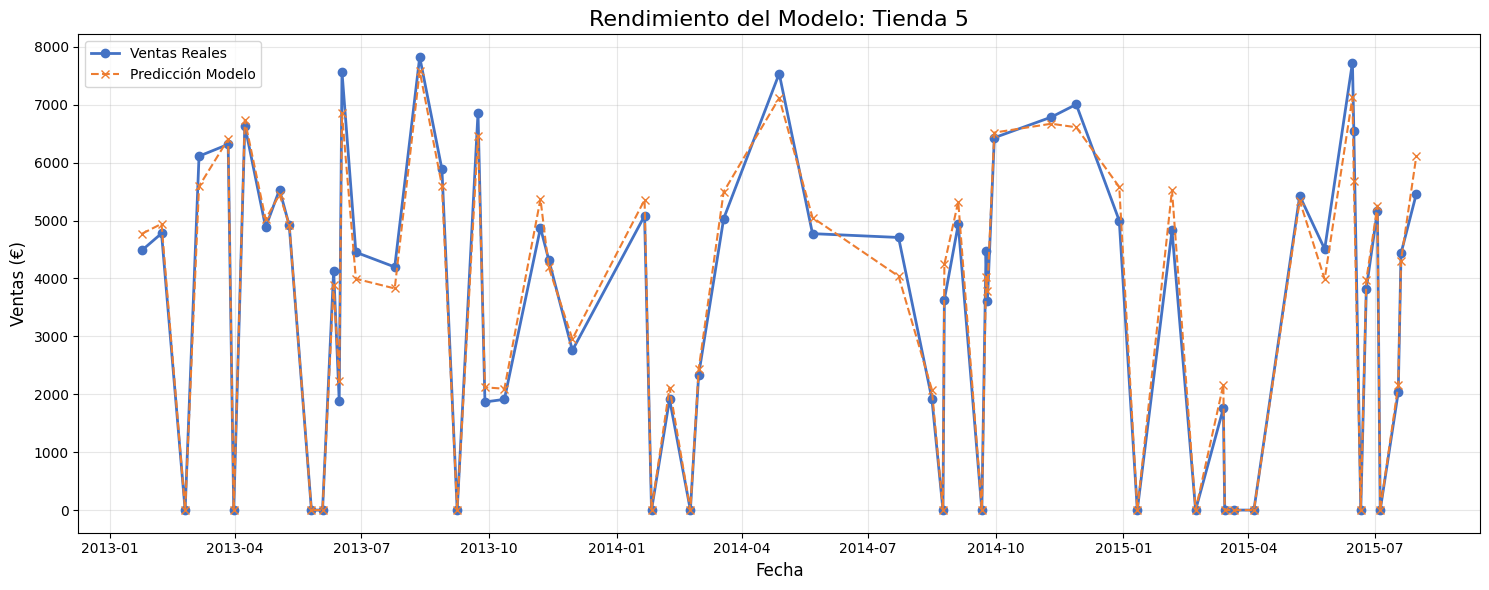

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargamos y unimos los datos (asegúrate de tener ambos archivos en tu carpeta)
df_pred = pd.read_csv('predicciones_con_columnas.csv')
df_sol = pd.read_csv('ironkaggle_solutions.csv')

# Estandarizamos nombres
df_pred.columns = df_pred.columns.str.lower()
df_sol.columns = df_sol.columns.str.lower()

# Unimos por el índice único
df_eval = pd.merge(df_pred, df_sol, on='true_index', suffixes=('_pred', '_real'))
df_eval['date'] = pd.to_datetime(df_eval['date'])

# 2. SELECCIONA LA TIENDA QUE QUIERAS VER
ID_TIENDA = 5  # <--- Cambia este número para ver otra tienda

subset = df_eval[df_eval['store_id'] == ID_TIENDA].sort_values('date')

# 3. GENERAMOS EL GRÁFICO
plt.figure(figsize=(15, 6))
plt.plot(subset['date'], subset['sales_real'], label='Ventas Reales', color='#4472C4', marker='o', linewidth=2)
plt.plot(subset['date'], subset['sales_pred'], label='Predicción Modelo', color='#ED7D31', linestyle='--', marker='x')

plt.title(f'Rendimiento del Modelo: Tienda {ID_TIENDA}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas (€)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()